In [157]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [158]:
rental, booking = (pd.read_csv(f"..\data\{filename}.csv") for filename in [
    "outdoorsy_rental_data", "outdoorsy_booking_history"
])

In [159]:
rental.head()

,rental_id,listing_state,vehicle_type,is_motorized,vehicle_make,vehicle_model,vehicle_year,vehicle_length,cancellation_policy,sleeps,is_festival_friendly,is_tailgate_friendly,is_pet_friendly,has_toilet,has_generator,has_inside_shower,has_refrigerator,has_wifi
0,206969964720,CA,trailer,False,Airstream,Safari,2008,20 - 25,flexible,4,False,True,True,True,False,True,True,False
1,374663654160,CA,c,True,Forest River,Sunseeker,2012,30 - 35,custom,9,True,True,False,True,True,True,True,False
2,436102091040,CA,c,True,forest river,Sunseeker,2011,30 - 35,strict,8,True,True,True,True,True,True,True,False
3,494831819280,MI,b,True,Leisure Travel,Serenity,2015,25 - 30,strict,4,False,False,True,True,True,True,True,False
4,645780764400,KY,a,True,Thor Motor Coach,Miramar,2016,35 - 40,moderate,10,True,True,False,True,True,True,True,False


In [163]:
# uniquely identified by rental_id
print(len(rental))
print(len(pd.unique(rental["rental_id"])))

3000
3000


In [164]:
booking.head()

,rental_id,booked_price_per_day,month_booked
0,25313374733280,$222.31,7
1,13557825481920,$146.93,11
2,18214711249680,$183.85,9
3,20892146617200,$271.92,7
4,25286903262480,$127.84,6


In [165]:
# not uniquely identified by rental_id & month_booked
print(len(booking))
print(len(np.unique(booking["rental_id"])))
print(len(booking.groupby(["rental_id", "month_booked"])))

3849
2792
3576


In [166]:
# in fact, there are some entirely duplicated records
dupes = booking.groupby(
    ["rental_id", "month_booked"]
).count().sort_values(
    by="booked_price_per_day", ascending=False
)
dupes.head()

,,booked_price_per_day
rental_id,month_booked,
8888134909680,6,4
22390431864480,6,4
29123542804800,7,4
4552600485120,12,4
8348116905360,6,3


In [167]:
mask = (booking["rental_id"]==dupes.index[0][0]) & (booking["month_booked"]==dupes.index[0][1])
booking[mask]

,rental_id,booked_price_per_day,month_booked
283,8888134909680,$92.59,6
1970,8888134909680,$92.59,6
1983,8888134909680,$86.33,6
2186,8888134909680,$86.33,6


In [168]:
# making the assumption that these completed duplicated records are data sanitation issues
booking = booking.drop_duplicates()

In [169]:
df = pd.merge(rental, booking, on="rental_id")

## data exploration

### 1. class c average rental value

In [170]:
df["vehicle_type"].value_counts()

trailer            1285
c                  1049
camper-van          539
b                   389
a                   314
fifth-wheel          83
truck-camper         62
toy-hauler           52
folding-trailer      46
Name: vehicle_type, dtype: int64

In [171]:
# need to combine numerical and string representations
df["month_booked"].value_counts()

6            712
7            664
8            525
9            473
10           472
11           364
12           325
5            233
July          10
September      9
June           8
August         6
December       6
October        6
May            3
November       3
Name: month_booked, dtype: int64

In [179]:
# because of string values, entire column is encoded as object
month_dict = {
    "January": "1",
    "February": "2",
    "March": "3",
    "April": "4",
    "May": "5",
    "June": "6",
    "July": "7",
    "August": "8",
    "September": "9",
    "October": "10",
    "November": "11",
    "December": "12"
}
df = df.assign(month_booked_num=df["month_booked"].replace(month_dict).astype(int))
df = df.drop_duplicates()  # in case month reassignment led to more data sanitation issues
assert df["month_booked_num"].dtype == int

In [182]:
df["month_booked_num"].value_counts()

6     720
7     674
8     531
9     482
10    478
11    367
12    331
5     236
Name: month_booked_num, dtype: int64

In [183]:
# uh-oh, some invalid entries in upstream data
# these should really be encoded as null
df["booked_price_per_day"].sort_values().head()

2208    #DIV/0!
1983    #DIV/0!
3220    #DIV/0!
3235      $0.36
1823      $0.86
Name: booked_price_per_day, dtype: object

In [184]:
df = df.assign(booked_price_per_day_num=df["booked_price_per_day"]
    .replace("[$,]", "", regex=True)  # remove the accounting characters
    .replace("#DIV/0!", np.nan)  # replace the div/0 with nulls (don't remove records)
    .astype(float)  # cast as float for numerical operations
)
df["booked_price_per_day_num"].sort_values() 

3235       0.36
1823       0.86
3647       1.13
3711       1.21
1822       2.57
         ...   
730     1270.65
1602    1520.93
1983        NaN
2208        NaN
3220        NaN
Name: booked_price_per_day_num, Length: 3819, dtype: float64

                        mean   median
month_booked_num                     
5                 215.907879  193.095
6                 212.971243  199.790
7                 233.187254  218.280
8                 240.465793  231.360
9                 245.674480  236.580
10                242.999286  230.860
11                234.897476  220.810
12                242.132326  219.720


<AxesSubplot:title={'center':'average monthly rental rates for class c RVs'}, xlabel='month_booked_num', ylabel='nightly rate ($)'>

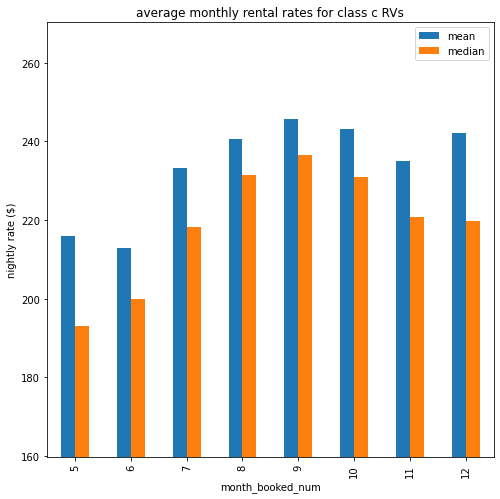

In [185]:
mask = df["vehicle_type"] == "c"  # only c-class RVs

# groupby and take average
# average frequently refers to mean, but can mean any aggregating function that summarizes data
# taking both mean and median (some robustness)
monthly_avg = df[mask].groupby(
    "month_booked_num", dropna=True
).agg([np.mean, np.median])["booked_price_per_day_num"]

print(monthly_avg)

# non-zero lower ylim (purely for visual comparison)
ymin, ymax = map(lambda f: f(monthly_avg["mean"]), [min, max])
monthly_avg.plot.bar(
    ylim=(ymin*.75, ymax*1.1), figsize=(8, 8),
    title="average monthly rental rates for class c RVs", ylabel="nightly rate ($)"
)

### 2. motorized vs non-motorized

In [186]:
df['is_motorized'].value_counts(normalize=True)

True     0.599895
False    0.400105
Name: is_motorized, dtype: float64

In [67]:
df = df.assign(vehicle_year_num=df["vehicle_year"].replace(0, np.nan).astype("Int64"))  # probably isn't 2,022 years old

yearly_motor_avg = df.groupby(
    ["vehicle_year_num", "is_motorized"], dropna=True
).agg(
    [np.mean, np.median, np.std, len]  # calculate within-group statistics
)["booked_price_per_day_num"]

yearly_motor_avg = yearly_motor_avg.reset_index()
yearly_motor_avg.sort_index()

,vehicle_year_num,is_motorized,mean,median,std,len
0,1945,False,86.560000,86.560,NaN,1
1,1962,False,99.510000,99.510,NaN,1
2,1965,False,134.080000,134.080,NaN,1
3,1971,True,146.990000,146.990,NaN,1
4,1972,True,194.330000,194.330,NaN,1
...,...,...,...,...,...,...
84,2020,True,305.964753,266.760,171.344095,224
85,2021,False,151.880769,143.240,52.543783,455
86,2021,True,316.259792,292.985,115.017553,289
87,2022,False,150.116818,140.905,32.832014,22


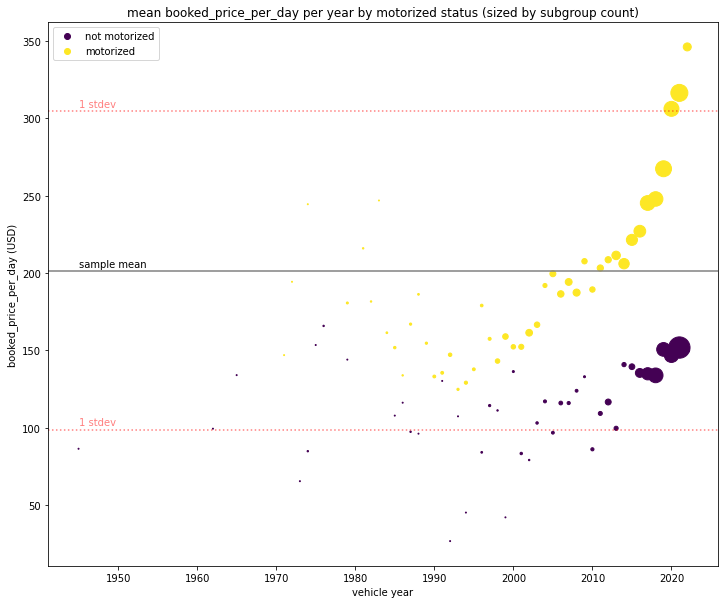

In [74]:
plt.figure(figsize=(12, 10))
scatter = plt.scatter(
    x=yearly_motor_avg["vehicle_year_num"],
    y=yearly_motor_avg["mean"],
    c=yearly_motor_avg["is_motorized"],  # color
    s=yearly_motor_avg["len"]
)
# add legend
plt.legend(handles=scatter.legend_elements()[0], labels=["not motorized", "motorized"])
plt.title("mean booked_price_per_day per year by motorized status (sized by subgroup count)")
plt.ylabel("booked_price_per_day (USD)")
plt.xlabel("vehicle year")

# add horizontal lines for mean and stdev
mu, sigma = map(lambda f: f(df["booked_price_per_day_num"]), [np.mean, np.std])
plt.axhline(y=mu, color="grey", linestyle='-')
text_x = yearly_motor_avg["vehicle_year_num"].min()
plt.text(text_x, mu*1.01, "sample mean")
for s in [mu+sigma, mu-sigma]:
    plt.axhline(y=s, color="red", linestyle=':', alpha=0.5)
    plt.text(text_x, s+3, "1 stdev",c='red', alpha=0.5)
plt.show()

In [64]:
within_std = df['booked_price_per_day_num'].between(mu-sigma, mu+sigma)
print((~within_std).sum())  # 796 properties outside of mean +- 1stdev 
print((~within_std).mean())  # ~20%

796
0.20680696284749286


### 3. location and seasonality

In [190]:
state_gb = df.groupby(
    ["listing_state"], dropna=True
).agg(
    [np.mean, len]  # calculate within-group statistics
)["booked_price_per_day_num"]

state_gb = state_gb.reset_index().sort_values(by="mean", ascending=False)
display(state_gb.head())
display(state_gb.tail())
# one dude in North Dakota swanked out
# what I'm guessing is New South Wales (AUS) has a bit of a beater

,listing_state,mean,len
30,ND,293.250000,1
33,NJ,291.855577,52
45,SC,264.651154,52
54,WV,249.432000,10
8,CT,237.721250,16


,listing_state,mean,len
34,NM,160.334500,20
53,WI,156.738444,45
44,RI,154.096000,5
3,AR,152.918667,15
35,NSW,65.620000,1


In [99]:
#https://plotly.com/python/choropleth-maps/#using-builtin-country-and-state-geometries
import plotly.express as px

fig = px.choropleth(
    locations=state_gb['listing_state'],
    locationmode="USA-states",
    color=state_gb['mean'],
    scope="usa",
    color_continuous_scale=px.colors.sequential.Viridis
)
fig.show()

<AxesSubplot:title={'center':'total booked price per month, may-december'}, xlabel='month_booked_num', ylabel='sum of booked_price_per_day, USD'>

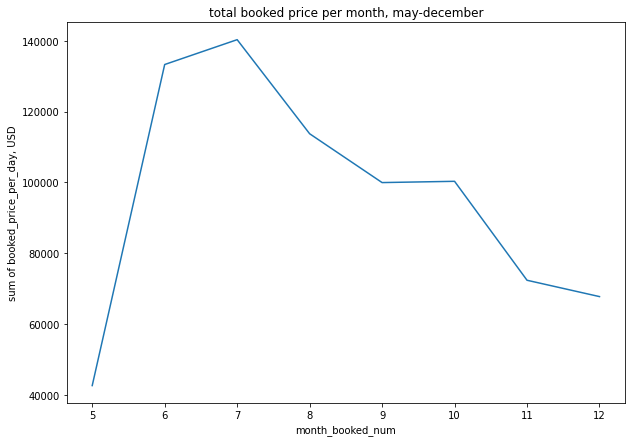

In [191]:
df.groupby("month_booked_num").sum()["booked_price_per_day_num"].plot(
    figsize=(10, 7), title="total booked price per month, may-december", ylabel="sum of booked_price_per_day, USD"
)

### modeling

In [194]:
pd.isnull(df).sum()

rental_id                     0
listing_state                19
vehicle_type                  0
is_motorized                  0
vehicle_make                 34
vehicle_model                23
vehicle_year                  0
vehicle_length                0
cancellation_policy         113
sleeps                        0
is_festival_friendly          0
is_tailgate_friendly          0
is_pet_friendly               0
has_toilet                    0
has_generator                 0
has_inside_shower             0
has_refrigerator              0
has_wifi                      0
booked_price_per_day          0
month_booked                  0
month_booked_num              0
booked_price_per_day_num      3
dtype: int64

In [247]:
# drop record when both vehicle make and model are null
mask = [pd.notnull(df[col]) for col in ["vehicle_make", "vehicle_model"]]
df_model = df[(mask[0]) | (mask[1])]  # inclusive or

In [248]:
# can we determine the make or model manually?
# with only 11 records, manual is feasible
make_mod_cols = ["vehicle_make", "vehicle_model"]
mask = [pd.isnull(df_model[col]) for col in make_mod_cols]
df_model[(mask[0]) | (mask[1])]  # inclusive or

,rental_id,listing_state,vehicle_type,is_motorized,vehicle_make,vehicle_model,vehicle_year,vehicle_length,cancellation_policy,sleeps,...,is_pet_friendly,has_toilet,has_generator,has_inside_shower,has_refrigerator,has_wifi,booked_price_per_day,month_booked,month_booked_num,booked_price_per_day_num
2667,27851557852080,GA,trailer,False,NaN,Bullet 330 BHS,2021,35 - 40,moderate,10,...,False,True,True,True,True,False,$183.99,7,7,183.99
2668,27851557852080,GA,trailer,False,NaN,Bullet 330 BHS,2021,35 - 40,moderate,10,...,False,True,True,True,True,False,$151.28,6,6,151.28
2887,28624401676320,CA,c,True,NaN,Greyhawk,2021,25 - 30,moderate,8,...,True,True,True,True,True,False,$320.47,12,12,320.47
2888,28624401676320,CA,c,True,NaN,Greyhawk,2021,25 - 30,moderate,8,...,True,True,True,True,True,False,$359.07,12,12,359.07
2889,28624401676320,CA,c,True,NaN,Greyhawk,2021,25 - 30,moderate,8,...,True,True,True,True,True,False,$357.28,6,6,357.28
3079,29241987246240,QC,c,True,NaN,CTV,2013,20 - 25,moderate,4,...,False,True,False,True,True,False,$180.14,11,11,180.14
3080,29241987246240,QC,c,True,NaN,CTV,2013,20 - 25,moderate,4,...,False,True,False,True,True,False,$224.65,10,10,224.65
3081,29241987246240,QC,c,True,NaN,CTV,2013,20 - 25,moderate,4,...,False,True,False,True,True,False,$459.65,6,6,459.65
3512,31217128337280,CO,c,True,NaN,Chateau Citation Sprinter,2017,20 - 25,flexible,6,...,True,True,True,True,True,False,$287.04,8,8,287.04
3513,31217128337280,CO,c,True,NaN,Chateau Citation Sprinter,2017,20 - 25,flexible,6,...,True,True,True,True,True,False,$246.58,10,10,246.58


In [249]:
pd.options.mode.chained_assignment = None  # I know what I'm doing, promise... 

# lower case and account for minimal formatting
# it would be an entire NLP effort to clean up, combine, and extract reliable make and models from this data
# consider adding trim/version column (eg: make=Ford, model=Econoline, trim=250s)
# consider implementing close-ended data input on the front-end, using industry make/model information

for col in make_mod_cols:
    df_model[col] = df_model[col].str.lower().replace("[-]", " ", regex=True)

In [254]:
# oh lordy
# set(df_model['vehicle_model'])

In [252]:
# object-oriented is the pythonic way...
df_model = df_model.dropna(subset=["booked_price_per_day_num"]).fillna("not specified (NaN)")
# either individually-identifying or superseded with numerical column
df_model = df_model.drop(["rental_id", "month_booked", "booked_price_per_day"], axis=1)

In [253]:
# an example of filling cancellation policy with NaN
# this could potentially be recoded as ordinal rather than categorical,
  # as there is a relationship between flexible, moderate, strict
pd.value_counts(df_model["cancellation_policy"], dropna=False)

moderate               1537
flexible               1489
strict                  623
not specified (NaN)     109
custom                   35
Name: cancellation_policy, dtype: int64

In [289]:
# vehicle length is a string, could be a useful numerical
df_model[["vehicle_length_min", "vehicle_length_max"]] = df_model["vehicle_length"].str.split(" - ", expand=True)
# still account for the >= 40ers
df_model["vehicle_length_min"] = df_model["vehicle_length_min"].str.replace(">= ", "").astype(int)
# this is not scientific, but filling in >=40 max with twice the range of other levels (40 + 5*2 = 50)
df_model["vehicle_length_max"] = df_model["vehicle_length_max"].fillna(50).astype(int)

In [291]:
df_model = df_model.drop(["rental_id", "month_booked", "booked_price_per_day", "vehicle_length"], axis=1)

In [292]:
df_model.dtypes

listing_state                object
vehicle_type                 object
is_motorized                   bool
vehicle_make                 object
vehicle_model                object
vehicle_year                  int64
cancellation_policy          object
sleeps                        int64
is_festival_friendly           bool
is_tailgate_friendly           bool
is_pet_friendly                bool
has_toilet                     bool
has_generator                  bool
has_inside_shower              bool
has_refrigerator               bool
has_wifi                       bool
month_booked_num              int32
booked_price_per_day_num    float64
vehicle_length_min            int32
vehicle_length_max            int32
dtype: object